In [1]:
import pandas as pd

medical_reports = pd.read_csv("reports.csv")
medical_reports

medical_specialty  \
0     Cardiovascular / Pulmonary   
1     Cardiovascular / Pulmonary   
2     Cardiovascular / Pulmonary   
3     Cardiovascular / Pulmonary   
4     Cardiovascular / Pulmonary   
...                          ...   
2174  Cardiovascular / Pulmonary   
2175  Cardiovascular / Pulmonary   
2176  Cardiovascular / Pulmonary   
2177  Cardiovascular / Pulmonary   
2178  Cardiovascular / Pulmonary   

                                                 report  
0     2-D M-MODE: , ,1.  Left atrial enlargement wit...  
1     1.  The left ventricular cavity size and wall ...  
2     2-D ECHOCARDIOGRAM,Multiple views of the heart...  
3     DESCRIPTION:,1.  Normal cardiac chambers size....  
4     2-D STUDY,1. Mild aortic stenosis, widely calc...  
...                                                 ...  
2174  INDICATION: , Chest pain.,TYPE OF TEST: , Aden...  
2175  CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...  
2176  HISTORY OF PRESENT ILLNESS: , The patient is a...  
2177  HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...  
2178  REASON FOR CONSULTATION:  ,Abnormal echocardio...  

[2179 rows x 2 columns]

In [2]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [3]:
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42)

grouped_data['medical_specialty'].value_counts()

medical_specialty
Cardiovascular / Pulmonary    110
Gastroenterology              110
Neurology                     110
Radiology                     110
Surgery                       110
Name: count, dtype: int64

In [4]:
val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)

val = val_test_data.groupby("medical_specialty").head(5)
test = val_test_data.groupby("medical_specialty").tail(5)

train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [5]:
len(train)

500

In [6]:
def num_tokens_from_string(string):
    import tiktoken
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens


# num_tokens_from_string("hello world how are you regularizationsuperduper")

In [7]:
report_lengths = train['report'].apply(num_tokens_from_string)

report_lengths

2135     634
1841     770
1823     232
2122     806
2047     260
        ... 
700      414
74      1287
470      500
880      552
357      348
Name: report, Length: 500, dtype: int64

In [8]:
report_lengths.describe()

count     500.000000
mean      674.788000
std       427.809075
min        14.000000
25%       358.000000
50%       593.500000
75%       904.000000
max      3701.000000
Name: report, dtype: float64

In [9]:
price_model = 0.008
price_per_epoch = report_lengths.sum() * price_model / 1000
price_per_epoch

2.699152

In [10]:
train['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [11]:
system_prompt = "Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

print(system_prompt)

Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery


In [12]:
sample_prompt = {"messages": [{"role": "system", "content": system_prompt}, 
                              {"role": "user", "content": train["report"].iloc[0]}, 
                              {"role": "assistant", "content": train["medical_specialty"].iloc[0]}]}

print(sample_prompt)

{'messages': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'}, {'role': 'user', 'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom.  With the help of 

In [13]:
def df_to_format(df):
    formatted_data = []

    for index, row in df.iterrows():
        entry = {"messages": [{"role": "system", "content": system_prompt}, 
                              {"role": "user", "content": row['report']}, 
                              {"role": "assistant", "content": row["medical_specialty"]}]}
        
        formatted_data.append(entry)
    return formatted_data
    
data = df_to_format(train)

In [14]:
data

[{'messages': [{'role': 'system',
    'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'},
   {'role': 'user',
    'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom.  With 

In [15]:
len(data)

500

In [16]:
import json

with open("fine_tuning_data.jsonl", "w") as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")

In [17]:
val_data = df_to_format(val)

with open("fine_tuning_data_val.jsonl", "w") as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")

In [18]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

from openai import OpenAI

client = OpenAI()

In [20]:
file_upload_response = client.files.create(file=open("fine_tuning_data.jsonl", "rb"), purpose="fine-tune")

In [21]:
file_upload_response

FileObject(id='file-1fxa2kLNg5iVutLngtacifqF', bytes=1543122, created_at=1708606175, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [23]:
file_upload_response_val = client.files.create(file=open("fine_tuning_data_val.jsonl", "rb"), purpose="fine-tune")
file_upload_response_val

FileObject(id='file-nDE7ttmZOxxoCZbVRnBlsee7', bytes=101459, created_at=1708606857, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [24]:
# fine_tuning_response = client.fine_tuning.jobs.create(training_file = file_upload_response.id,
#                                                       model = 'gpt-3.5-turbo',
#                                                       hyperparameters = {'n_epochs': 1},
#                                                       validation_file = file_upload_response_val.id
#                                                       )

In [25]:
fine_tuning_response

FineTuningJob(id='ftjob-hncc2HpjW6RZ6rEev4OBhikC', created_at=1708608608, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-VlD9wSlveZjjCSKgMu4Ywn24', result_files=[], status='validating_files', trained_tokens=None, training_file='file-1fxa2kLNg5iVutLngtacifqF', validation_file='file-nDE7ttmZOxxoCZbVRnBlsee7')

In [27]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-hncc2HpjW6RZ6rEev4OBhikC', created_at=1708608608, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-VlD9wSlveZjjCSKgMu4Ywn24', result_files=[], status='running', trained_tokens=None, training_file='file-1fxa2kLNg5iVutLngtacifqF', validation_file='file-nDE7ttmZOxxoCZbVRnBlsee7')], object='list', has_more=False)

In [40]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-hncc2HpjW6RZ6rEev4OBhikC', created_at=1708608608, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0613:personal::8v3nKrtI', finished_at=1708609973, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-VlD9wSlveZjjCSKgMu4Ywn24', result_files=['file-bPCUn5CH0HoCkqoXVys3J2hK'], status='succeeded', trained_tokens=361594, training_file='file-1fxa2kLNg5iVutLngtacifqF', validation_file='file-nDE7ttmZOxxoCZbVRnBlsee7')], object='list', has_more=False)

In [41]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-hncc2HpjW6RZ6rEev4OBhikC", limit=500)

In [47]:
train_event.data[2].data

{'step': 491,
 'train_loss': 3.8205008506774902,
 'valid_loss': 3.337860107421875e-06,
 'total_steps': 500,
 'train_mean_token_accuracy': 0.75,
 'valid_mean_token_accuracy': 0.25}

In [48]:
train_loss = []
val_loss = []

for item in train_event.data:
    train_data = item.data
    if train_data and "train_loss" in train_data:
        train_loss.insert(0, train_data['train_loss'])
        val_loss.insert(0, train_data['valid_loss'])

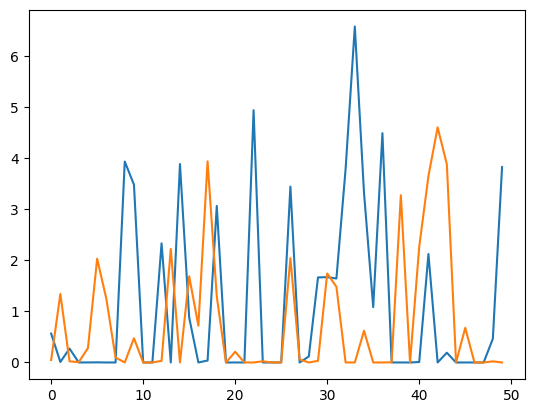

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

In [52]:
completion = client.chat.completions.create(model="ft:gpt-3.5-turbo-0613:personal::8v3nKrtI",
                                            messages=[
                                                {"role": "system", "content": system_prompt},
                                                {"role": "user", "content": test["report"].iloc[1]}
                                            ])

In [53]:
completion.choices[0].message

ChatCompletionMessage(content='Cardiovascular / Pulmonary', role='assistant', function_call=None, tool_calls=None)

In [69]:
def classify_report(report, model):
    completion = client.chat.completions.create(model=model,
                                            messages=[
                                                {"role": "system", "content": system_prompt},
                                                {"role": "user", "content": report}
                                            ])
    return completion

In [70]:
predicted_classes = []
ground_truth_classes = []

for line in test.iterrows():
    report, specialty = line[1]['report'], line[1]['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report, model = "gpt-3.5-turbo")
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [71]:
import numpy as np

(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.16

In [72]:
predicted_classes = []
ground_truth_classes = []

for line in test.iterrows():
    report, specialty = line[1]['report'], line[1]['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report, model = "ft:gpt-3.5-turbo-0613:personal::8v3nKrtI")
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [73]:
import numpy as np

(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.56